# Gather insights from the experiments run on GCP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [2]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

In [3]:
# function to get the best results and the parameters for them
def get_best_combinations(ml: pd.DataFrame, column: str):
    """
    Given a dataframe, return the options with the best TTA and the column to optimize
    """
    
    # get only the non object columns
#     ml = ml[[col for col in ml.columns if ml[col].dtype != 'object']]

    # get the minimum rown of each of the batch sizes
    min_rows = ml.groupby('batch_size')[column].min()
    best = ml.loc[ml[column].isin(min_rows.values)][['k', 'batch_size', 'parallelism']]

    # get the rows with those combinations
    return ml.merge(best)

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [ ]:
import glob
glob.glob('./results/cpu/train/*.pkl')

In [ ]:
df = join_df('./results/cpu/train/')
# df = df[df.default_parallelism > 1]

In [ ]:
df['momentum'] = False
# df=pd.concat([df,mom], ignore_index=True)

In [ ]:
df

In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [ ]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [ ]:
# compute the ttas
df['tta_80'] = tta(80, df)
df['tta_cross_80'] = tta_crossbow(80, df)

# compute the ttas
df['tta_67'] = tta(67, df)
df['tta_cross_67'] = tta_crossbow(67, df)

# compute the ttas
df['tta_70'] = tta(70, df)
df['tta_cross_70'] = tta_crossbow(70, df)

### For the metrics in resnet

In [ ]:
metrics = join_df('./results/resnet_sparse/metrics')
m = metrics.rename(columns={'exp_name':'id'})

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [ ]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [ ]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/resnet_kubeml_sparse.pkl')


In [ ]:
df.to_pickle('./dataframes/lenet-cpu-6-workers.pkl')

# TensorFlow Experiments

How to treat the TF experiments

In [ ]:
folder = 'lenet'
df = join_df(f'./results/tf/{folder}/train_full/1/', f'./results/tf/{folder}/train_full/2', f'./results/tf/{folder}/train_full/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [ ]:
#tta_lenet
df['tta_99'] = tta(0.99, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_99'] = tta_crossbow(0.99, df, time_column='times', acc_column='val_accuracy')

In [ ]:
# Define the TTA
df['tta_67'] = tta(0.67, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_67'] = tta_crossbow(0.67, df, time_column='times', acc_column='val_accuracy')

df['tta_69'] = tta(0.69, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_69'] = tta_crossbow(0.69, df, time_column='times', acc_column='val_accuracy')

df['tta_70'] = tta(0.70, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_70'] = tta_crossbow(0.70, df, time_column='times', acc_column='val_accuracy')


## Merge the metrics from different  folders


In [ ]:
m = join_df(f'./results/tf/{folder}/metrics_full/1/', f'./results/tf/{folder}/metrics_full/2', f'./results/tf/{folder}/metrics_full/3')

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [ ]:
df = df.join(m)

Save the experiments

In [ ]:
df.to_pickle('./dataframes/lenet_full_tensorflow.pkl')

In [ ]:
df

# Visualization of Results


Set the color palette

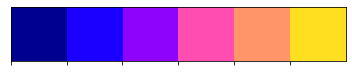

In [4]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette('gnuplot2'))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
sns.set_context('talk')
# sns.set_palette(blue_yellow_palette)

In [ ]:
a = sns.color_palette('gnuplot2').as_hex()
a

# Read the experiments file

Some of the dataframes by name

- resnet_new: is with extra epochs and proper preprocessing
- resnet_sparse: only holds the tests with sparse averaging
- folders with metrics/train_full hold the extra experiment to migrate to local batch comparison

### Load all of the dataframes

In [ ]:
# load the tf experiments
resnet = pd.read_pickle('./dataframes/resnet_new_full_tensorflow.pkl')
lenet = pd.read_pickle('./dataframes/lenet_full_tensorflow.pkl')

lenet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
lenet['system'] = 'tensorflow'
lenet['acc'] = 100*lenet['acc']
lenet['accuracy'] = lenet['accuracy'].map(lambda l: [100*n for n in l])

# rename columns in the TF dataframes to adhere to the kubeml ones
resnet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
resnet['system'] = 'tensorflow'
resnet['acc'] = 100*resnet['acc']
resnet['accuracy'] = resnet['accuracy'].map(lambda l: [100*n for n in l])


# set the columns of the 

# load the kubeml experiments
kuberesnet = pd.read_pickle('./dataframes/resnet_kubeml.pkl')
kuberesnet['model'] = 'resnet'
kuberesnet['system'] = 'kubeml'
# kuberesnet['tta_70'] = tta(70, kuberesnet)
# kuberesnet['tta_cross_70'] = tta_crossbow(70, kuberesnet)

kubelenet = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
kubelenet['model'] = 'lenet'
kubelenet['system'] = 'kubeml'


In [ ]:
kubelenet

In [ ]:
# save the full resnet stuff
r.to_pickle('./dataframes/resnet_new_full.pkl')

In [ ]:
r = pd.concat([resnet, kuberesnet], ignore_index=True)
r
# resnet

### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


# Plot the resnet results KubeML vs Tensorflow

In [ ]:
#Define the colors used
tf_color = '#FF6F00'
kubecolor = '#316CE6'



## LeNet Results

In [ ]:
l = pd.read_pickle('./dataframes/lenet.pkl')

In [ ]:
len(l[l.system=='tensorflow'].iloc[0].accuracy)

## Get the best result from Lenet

In [ ]:
sns.set_palette('gnuplot2')
sns.set_context('poster')
# sns.set(font_scale=)
sns.set_style('whitegrid')


tf = l[l.system=='tensorflow']
tf['train_accuracy'] = tf.train_accuracy.map(lambda l: [100*n for n in l])
best = tf.sort_values('tta_99').head(1).iloc[0]

max_acc = np.max(best.accuracy)
max_acc

# before it was 10,5
plt.figure(figsize=(10, 9))
sns.lineplot(x=best.epoch_duration,
            y=99,
            color='red',
            )

# 1) plot the validation accuracy of TF
sns.lineplot(x=best.epoch_duration,
             y=best.accuracy,
             data=best,  
            label='Test Accuracy',
#              color=tf_color
            )

line = sns.lineplot(x=best.epoch_duration,
             y=best.train_accuracy,
             data=best,  
            label='Train Accuracy',
            color='gray',
            alpha=.6
            )

size = 35

# plt.ylim([30, 80])
plt.xlabel('Time (sec)', fontsize=size)
plt.ylabel("Accuracy (%)", fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)

line.lines[2].set_linestyle((0, (15, 6)))

# sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/lenet-baseline.pdf')

In [ ]:
tf.sort_values('tta_99')['tta_99']

### Plot the Accuracy and Train Loss Progression

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 6))

# get the best results
tf = l[l.system=='tensorflow']
ml = l[l.system =='kubeml']
sample = tf.iloc[14]
kubesample = ml.iloc[87]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([97, 100])
ax1.set_xlabel('Time (sec)')



# plot the line at 69%
sns.lineplot(x=kubesample.epoch_duration,
            y=99,
            ax=ax1,
            color='red')

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')

ax2.set_xlabel('Time (sec)')



# 4) Plot the val loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.validation_loss[:30],
             data=sample, 
            ax=ax3, 
            label='TensorFlow',
            color='#FF6F00')

# 4) Plot the val loss
sns.lineplot(x=kubesample.epoch_duration,
             y='validation_loss',
             data=kubesample, 
            ax=ax3, 
            label='KubeML',
            color='#316CE6')

ax3.set_ylim([0, 0.3])

# plt.savefig('./figures/ppt/lenet_line.png', dpi=300)


### Plot the whole comparison

In [ ]:
l

In [ ]:
# get only the results with k=-1 and 
# _l = l[((l.parallelism==4) | (l.parallelism.isna())) & ((l.k==float('inf')) | (l.k.isna())) ]

tf = l[l.system=='tensorflow']
ml = l[l.system=='kubeml']

tf['local_batch'] = (tf.batch_size/2).astype('int')

# get the best results
ml = get_best_combinations(ml, 'tta_99')
# display(ml)
ml['local_batch'] = ml.batch_size
# print(ml.groupby('batch_size').median())

# combine them again
_l = pd.concat([tf, ml])
_l.system = _l.system.map(lambda val: 'KubeML' if val=='kubeml' else 'TensorFlow')
_l = _l[_l.local_batch >8]

# set the palette
sns.set_palette([tf_color, kubecolor])


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(figsize=(10, 7))

size = 30

# 1) Plot the comparison of tta between both
sns.barplot(x='local_batch', 
            y='tta_99', 
            data=_l, 
            hue='system', 
            errwidth=2.5,
#             ax=ax[0][0],
           capsize=.05)

# set sizes for good visibility
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('TTA (99%) (sec)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)

sns.despine(left=True)
plt.ylim([0, 150])
plt.tight_layout()
plt.savefig('./figures/paper/lenet/tta99.pdf')




# 3) Plot the difference train_loss
f, ax = plt.subplots(figsize=(10, 7))
_l['t_loss'] = _l['train_loss'].map(lambda l:l[-1])
sns.barplot(x='local_batch', 
            y='t_loss', 
            data=_l, 
            hue='system',
            errwidth=2.5,
#             ax=ax[1][0],
            capsize=.05,
               )
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Train Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)

# plt.ylim([0, 0.8])
sns.despine(left=True)
plt.tight_layout()
plt.savefig('./figures/paper/lenet/train-loss.pdf')


# 4) Plot the val loss of both compared
# calculate the loss
f, ax = plt.subplots(figsize=(10, 7))
_l['loss'] = _l['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='local_batch', 
            y='loss', 
            data=_l ,
            hue='system',
            errwidth=2.5,
#             ax=ax[1][1],
            capsize=.05)

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Validation Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
plt.ylim([0, 0.08])
sns.despine(left=True)
plt.tight_layout()
plt.savefig('./figures/paper/lenet/val-loss.pdf')


## Plot the difference in cpu and gpu utilization
# CPU util
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='local_batch', 
            y='cpu_mean', 
            data=_l ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
#             ax=ax[2][0]
           )

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('CPU Utilization (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
sns.despine(left=True)
plt.ylim([0, 15])
plt.tight_layout()
plt.savefig('./figures/paper/lenet/cpu.pdf')




ml = l[l.system=='kubeml']
ml['local_batch'] = ml['batch_size']

tf = l[l.system=='tensorflow']
tf['parallelism'] = 'tf'
tf['local_batch'] = tf['batch_size']/2
tf['k'] = 1

_l = pd.concat([tf, ml])
_l.gpu_usage = _l.gpu_usage.map(lambda v: 100*v)
_l = _l[_l.local_batch > 8]
_r = _l[_l.k.eq(1) | _l.k.eq(float('inf'))]
sns.set_palette('gnuplot2')



# Global Batch Size relationship with tta
# _ml = r[r.system=='kubeml']
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='local_batch', 
            y='gpu_usage', 
            data=_l ,
            capsize=.05,
            errwidth=2.5,
            hue='parallelism',
            hue_order=['tf', 2, 4, 8],
            errcolor='gray',
#             ax=ax[2][1]
           )

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('GPU Usage (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=20)
# plt.ylim([10, 130])
sns.despine(left=True)
plt.tight_layout()

plt.savefig('./figures/paper/lenet/gpu.pdf')
# plt.savefig('./figures/ppt/lenet-performance.png', dpi=400)

In [ ]:
_r.gpu_0_mean_usage.min()

In [ ]:
_l[_l.local_batch==32].groupby('system').mean()['tta_99']

In [ ]:
_l[_l.system=='KubeML'].groupby('batch_size')['parallelism'].mean()

### Comparison of accuracy and time between K

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.set_palette('gnuplot2', desat=0.8)



_kubelenet = l[(l.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='parallelism',
           ax=ax[0],
           errcolor='gray',
           capsize=.05,
           errwidth=2.5)
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Time (sec)')


_kubelenet = l[(l.system == 'kubeml') & (l.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='acc',
           data=_kubelenet, 
           hue='parallelism',
           ax=ax[1],
           errcolor='gray',
           capsize=.05,
           errwidth=2.5)
ax[1].set_xlabel('Batch Size')
ax[1].set_ylabel('Time (sec)')

plt.suptitle('Evolution of Time with Parallelism and K')

plt.savefig('./figures/ppt/lenet-time.png', dpi=400)

## Resnet Results

#### Plot the Train Loss and Val Accuracy of Tensorflow and KubeML


In [ ]:
#Define the colors used
tf_color = '#FF6F00'
kubecolor = '#316CE6'



In [ ]:
# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.7)

In [ ]:
r = pd.read_pickle('./dataframes/resnet_sparse.pkl')

## Get the best result plot from Resnet

In [ ]:
tf = r[r.system=='tensorflow']

sns.set_palette('gnuplot2')

tf['train_accuracy'] = tf.train_accuracy.map(lambda l: [100*n for n in l])


best = tf.sort_values('tta_70').head(1).iloc[0]




max_acc = np.max(best.accuracy)
max_acc


plt.figure(figsize=(10, 9))
# 1) plot the validation accuracy of TF
sns.lineplot(x=best.epoch_duration,
             y=best.accuracy,
             data=best,  
            label='Test Accuracy',
#              color=tf_color
            )

l = sns.lineplot(x=best.epoch_duration,
             y=best.train_accuracy,
             data=best,  
            label='Train Accuracy',
            color='gray',
            alpha=.6
            )


sns.lineplot(x=best.epoch_duration,
            y=70,
            color='red',
            )
# plt.ylim([30, 80])
size = 35

# plt.ylim([30, 80])
plt.xlabel('Time (sec)', fontsize=size)
plt.ylabel("Accuracy (%)", fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)

l.lines[1].set_linestyle((0, (15, 6)))

# sns.despine()

plt.tight_layout()
plt.savefig('./figures/paper/resnet-baseline.pdf')

In [ ]:
r[(r.batch_size==32) & (r.system=='kubeml') & (r.k == float('inf')) & (r.parallelism ==4)].iloc[0].epoch_duration

In [ ]:
print(sns.color_palette('gnuplot2').as_hex())

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 6))

# get the best results
tf = r[r.system=='tensorflow']
ml = r[r.system =='kubeml']
sample = r.iloc[tf.sort_values('tta_70').head(1).index[0]]
kubesample = r.iloc[ml.sort_values('tta_70').head(3).index[0]]

# kubesample =ml.iloc[2]
# sample = tf.iloc[3]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:50],
             y=sample.accuracy[:50],
             data=sample, 
            ax=ax1, 
            label='TensorFlow')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML')

ax1.set_ylim([40, 80])



# plot the line at 70%
sns.lineplot(x=range(int(kubesample.time)),
            y=70,
            ax=ax1,
            color='red')


# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML')


# 4) Plot the val loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.validation_loss[:30],
             data=sample, 
            ax=ax3, 
            label='TensorFlow')

# 4) Plot the val loss
sns.lineplot(x=kubesample.epoch_duration,
             y='validation_loss',
             data=kubesample, 
            ax=ax3, 
            label='KubeML')

# plt.savefig('./figures/ppt/resnet_line.png', dpi=300)


### Plot the GPU, CPU and MEM usage based on k, batch and parallelism

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 6))
sns.set_palette('deep')

# 1) Plot the cpu usage
sns.barplot(x='batch_size', 
            y='cpu_mean', 
            data=ml, 
            hue='k', 
            errwidth=2.5,
            ax=ax1,
            capsize=.05)
# ax1.set_ylim([40, 100])
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('CPU Usage (%)')


# 2) Plot the memory usage
sns.barplot(x='batch_size', 
            y='mem_mean', 
            data=ml, 
            hue='parallelism',
            errwidth=2.5,
            ax=ax2,
            capsize=.05,
               )
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Memory Usage (%)')


# 3) Plot the gpu usage
sns.barplot(x='batch_size', 
            y='gpu_usage', 
            data=ml ,
            hue='k',
            errwidth=2.5,
            ax=ax3,
            capsize=.05)

ax3.set_xlabel('Batch Size')
ax3.set_ylabel('GPU Usage')

In [ ]:
ml[(ml.parallelism==4) & (ml.k==float('inf')) & (ml.batch_size==128)].time

In [ ]:
_ml.groupby('batch_size')['tta_70'].mean()

### Plot the metrics of both 

In [ ]:
_s['parallelism'].value_counts()

In [ ]:
_ml[['batch_size', 'k', 'parallelism', 'epochs']]

In [ ]:
d = pd.read_pickle('./dataframes/resnet_new_full.pkl')

In [ ]:
# get only the results with k=-1 and 
# _r = r[((r.parallelism==4) | (r.parallelism.isna())) & ((r.k==float('inf')) | (r.k.isna())) ]
# _r['t30'] = _r['time']

sns.set_palette([tf_color, kubecolor])

size=25

sns.set_style('whitegrid')
plt.rc('font', size=22)

_r = pd.read_pickle('./dataframes/resnet_new_full.pkl')
_sp = pd.read_pickle('./dataframes/resnet_sparse.pkl')
_sp = _sp[_sp.system=='kubeml']

_s = pd.concat([_r,_sp])
_tf = _s[_s.system=='tensorflow']
_tf['parallelism'] = 'tf'
_tf['local_batch'] = (_tf.batch_size/2).astype('int')

_ml = _s[_s.system=='kubeml']
_ml['local_batch'] = _ml['batch_size']
_ml = get_best_combinations(_ml, 'tta_70')


_r = pd.concat([_tf,_ml])
_r.system = _r.system.map(lambda val: 'KubeML' if val=='kubeml' else 'TensorFlow')
_r = _r[_r['local_batch'] >16]

# display(_ml)




# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(figsize=(10, 7))

# 1) Plot the comparison of tta between both
sns.barplot(x='local_batch', 
            y='tta_70', 
            data=_r, 
            hue='system', 
            errwidth=2.5,
#             ax=ax[0][0],
           capsize=.05)
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('TTA (70%) (sec)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
sns.despine(left=True)
# plt.setp(ax.get_legend().get_texts(), fontsize='15') 
# plt.setp(ax.get_legend().get_title(), fontsize='15')  
plt.tight_layout()
plt.savefig('./figures/paper/resnet34/tta70.pdf')

# # create a function
# for (i, row), p in zip(parals.iterrows(), [p for p in ax[0][0].patches[1::2]]):
#     print(row, p)
#     ax[0][0].annotate(
#         str(int(row.parallelism)),
#         xy = ( p.get_x() + p.get_width(),  p.get_height() + 10))


# 3) Plot the difference train_loss
f, ax = plt.subplots(figsize=(10, 7))
_r['t_loss'] = _r['train_loss'].map(lambda l:l[-1])
sns.barplot(x='local_batch', 
            y='t_loss', 
            data=_r, 
            hue='system',
            errwidth=2.5,
#             ax=ax[1][0],
            capsize=.05,
               )
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Train Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
plt.ylim([0, 0.65])
sns.despine(left=True)
plt.tight_layout()
plt.savefig('./figures/paper/resnet34/train-loss.pdf')


# 4) Plot the val loss of both compared
# calculate the loss
f, ax = plt.subplots(figsize=(10, 7))
_r['loss'] = _r['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='local_batch', 
            y='loss', 
            data=_r ,
            hue='system',
            errwidth=2.5,
#             ax=ax[1][1],
            capsize=.05)

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Validation Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
plt.ylim([0, 3.25])
sns.despine(left=True)
plt.tight_layout()
plt.savefig('./figures/paper/resnet34/val-loss.pdf')


## Plot the difference in cpu and gpu utilization
# CPU util
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='local_batch', 
            y='cpu_mean', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
#             ax=ax[2][0]
           )

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('CPU Utilization (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
sns.despine(left=True)
plt.ylim([0, 15])
plt.tight_layout()
plt.savefig('./figures/paper/resnet34/cpu.pdf')


_sp = pd.read_pickle('./dataframes/resnet_sparse.pkl')
_sp = _sp[_sp.system=='kubeml']
_sp['local_batch'] = _sp['batch_size']
_ml = _s[_s.system=='kubeml']
_ml['local_batch'] = _ml['batch_size']
_tf['k'] = 1



_r = pd.concat([_tf, _ml, _sp], ignore_index=True)
_r = _r[_r['local_batch'] >16]
_r.gpu_usage = _r.gpu_usage.map(lambda v: 100*v)
_r = _r[_r.k.eq(1) | _r.k.eq(float('inf'))]
sns.set_palette('gnuplot2')



# Global Batch Size relationship with tta
# _ml = r[r.system=='kubeml']
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='local_batch', 
            y='gpu_usage', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            errcolor='gray',
            hue='parallelism',
            hue_order=['tf', 2, 4, 8],
#             ax=ax[2][1]
           )

plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('GPU Usage (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=20)
plt.ylim([10, 130])
sns.despine(left=True)
plt.tight_layout()
plt.savefig('./figures/paper/resnet34/gpu.pdf')


In [ ]:
_r.sort_values('parallelism')

In [ ]:
 ax.annotate(str(int(p)), 
                xy=(patch.get_x()+patch.get_width()/1.3, patch.get_height()+ 10), 
                ha='center', 
                fontsize=20, 
                color='red')

In [ ]:
def annotate_rectangles(df:pd.DataFrame):
    """Do the stuff"""

In [ ]:
parals = ml.groupby('batch_size').mean()[['parallelism', 'tta_70']]
# parals
for (i, row), p in zip(parals.iterrows(), [p for p in ax[0][0].patches[1::2]]):
    print(row, p)
    ax[0][0].annotate(
        str(int(row.parallelism)),
        xy = ( p.get_x() + p.get_width(),  p.get_height() + 10))

### Get the best results of KubeML by  Batch

In [ ]:
ml[ml.batch_size.eq(256) & ~ml.tta_70.isna()]['tta_70']

In [ ]:
ml = r[r.system=='kubeml']
ml = get_best_combinations(ml)
ml
_r = pd.concat([tf, ml], ignore_index=True)

In [ ]:
sns.set_palette('deep', 10)
sns.set_style('whitegrid')

def get_best_combinations(ml: pd.DataFrame):
    """
    Given a dataframe, return the options with the best TTA
    """
    
    # get only the non object columns
#     ml = ml[[col for col in ml.columns if ml[col].dtype != 'object']]

    # get the minimum rown of each of the batch sizes
    min_rows = ml.groupby('batch_size')['tta_70'].min()
    best = ml.loc[ml.tta_70.isin(min_rows.values)][['k', 'batch_size', 'parallelism']]

    # get the rows with those combinations
    return ml.merge(best)
    
f, ax = plt.subplots(figsize=(10, 6))

ml = r[r.system=='kubeml']
ml = get_best_combinations(ml)

sns.barplot(x='batch_size',
           y='tta_70', 
            data=ml,
           errwidth=2.5,
            capsize=.05, 
           )

ps = ml.groupby('batch_size').mean()[['parallelism', 'tta_70']]
for i, ((_, p, tta), patch) in enumerate(zip(ps.itertuples(), ax.patches)):
    print(patch)
    
    ax.annotate(str(int(p)), 
                xy=(patch.get_x()+patch.get_width()/1.3, patch.get_height()+ 10), 
                ha='center', 
                fontsize=20, 
                color='red')
    



### Comparison of Time with Parallelism and K 

(include these in paper!!)

In [ ]:
# f, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 15))

# palette using colors derived from the kubernetes blue
custom_palette = ["#1f438f","#316ce6","#358be1","#6899b5","#908389","#b86d5c","#d63230"]

size


# sns.set_palette('muted',10)
# sns.set_palette(custom_palette, desat=0.8)
sns.set_palette('gnuplot2')



_kuberesnet = _s[(_s.system == 'kubeml')]
_kuberesnet['parallelism'] = _kuberesnet.parallelism.astype('int')
_kuberesnet['global_batch'] = _kuberesnet.global_batch.astype('int')
_kuberesnet['k'] = _kuberesnet.k.map(lambda v: int(v) if v != float('inf') else v)


f, ax = plt.subplots(figsize=(10,7))
print(_kuberesnet.parallelism.value_counts())
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            errwidth=2.5,
            capsize=.05,
            errcolor='gray',
           hue='parallelism',
           )
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Time (sec)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=25)

sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/batch-vs-time-by-parallelism.pdf')





# _kuberesnet = r[(r.system == 'kubeml') & (r.parallelism==4)]
# 2) plot the time reached with different k
f, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            capsize=.05,
           hue='k',
            errcolor='gray',
        errwidth=2.5)
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Time (sec)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='k', fontsize=25)

sns.despine(left=True)


plt.tight_layout()
plt.savefig('./figures/paper/resnet34/batch-vs-time-by-k.pdf')



# _kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
# sns.barplot(x='batch_size',
#            y='acc',
#            data=_kuberesnet, 
#            hue='parallelism',
#             errcolor='gray',
#             capsize=.05,
#             errwidth=2.5,
#            ax=ax2[0])
# ax2[0].set_xlabel('Batch Size')
# ax2[0].set_ylabel('Accuracy (%)')
# ax2[0].set_ylim([55, 73])


# _kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k

f, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='global_batch',
           y='acc',
            errwidth=2.5,
            capsize=.05,
            errcolor='gray',
           data=_kuberesnet, 
           hue='parallelism')
plt.xlabel('Global Batch Size', fontsize=size)
plt.ylabel('Accuracy (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=25)
plt.legend
plt.ylim([55, 80])
sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/global-batch-vs-acc.pdf')




f, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='batch_size',
           y='acc',
            errwidth=2.5,
            capsize=.05,
            errcolor='gray',
           data=_kuberesnet, 
           hue='k')
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Accuracy (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='k', fontsize=20)
plt.legend
plt.ylim([40, 100])
sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/global-batch-vs-acc-k.pdf')


# plt.suptitle('Evolution of Time with Parallelism and K (Resnet34)')

# plt.savefig('./figures/ppt/resnet-time.png', dpi=400)

## Plot a comparison of progress by K, parallelism in terms of val loss and train loss

In [5]:
r = pd.read_pickle('./dataframes/resnet_new_full.pkl')
sp = pd.read_pickle('./dataframes/resnet_sparse.pkl')



In [ ]:
sp.parallelism.value_counts()

In [6]:
print(sns.color_palette('gnuplot2').as_hex())

palette = sns.color_palette('gnuplot2').as_hex()[1:]
sns.set_palette(palette)

['#000090', '#1d00ff', '#8d04fb', '#ff4eb1', '#ff9669', '#ffe01f']


In [88]:
r4.k

inf

[2021-05-17 19:22:14,918] DEBUG    Assigning font /b'F1' = 'C:\\Windows\\Fonts\\arial.ttf'
[2021-05-17 19:22:14,943] DEBUG    Embedding font C:\Windows\Fonts\arial.ttf.
[2021-05-17 19:22:14,943] DEBUG    Writing TrueType font.
[2021-05-17 19:22:15,104] DEBUG    Assigning font /b'F1' = 'C:\\Windows\\Fonts\\arial.ttf'
[2021-05-17 19:22:15,129] DEBUG    Embedding font C:\Windows\Fonts\arial.ttf.
[2021-05-17 19:22:15,129] DEBUG    Writing TrueType font.
[2021-05-17 19:22:15,299] DEBUG    Assigning font /b'F1' = 'C:\\Windows\\Fonts\\arial.ttf'
[2021-05-17 19:22:15,326] DEBUG    Embedding font C:\Windows\Fonts\arial.ttf.
[2021-05-17 19:22:15,327] DEBUG    Writing TrueType font.
[2021-05-17 19:22:15,499] DEBUG    Assigning font /b'F1' = 'C:\\Windows\\Fonts\\arial.ttf'
[2021-05-17 19:22:15,525] DEBUG    Embedding font C:\Windows\Fonts\arial.ttf.
[2021-05-17 19:22:15,526] DEBUG    Writing TrueType font.


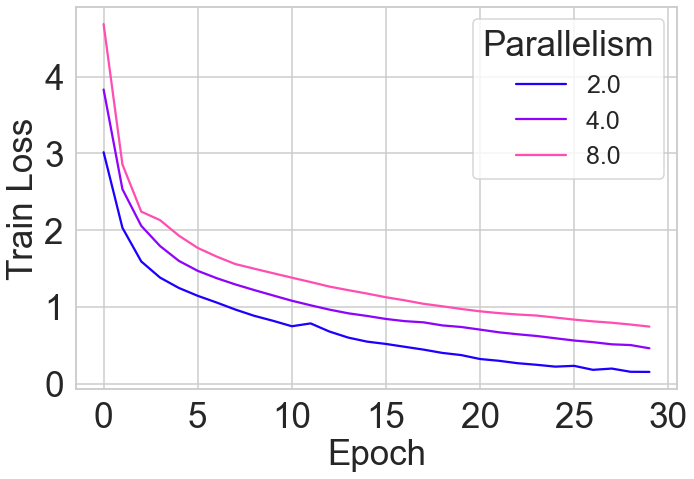

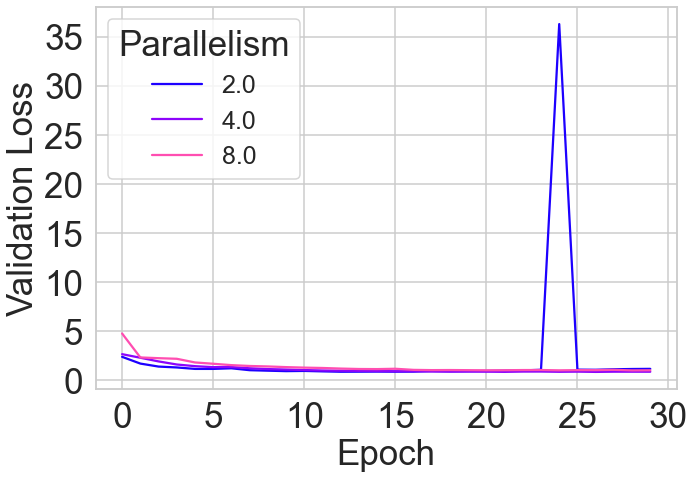

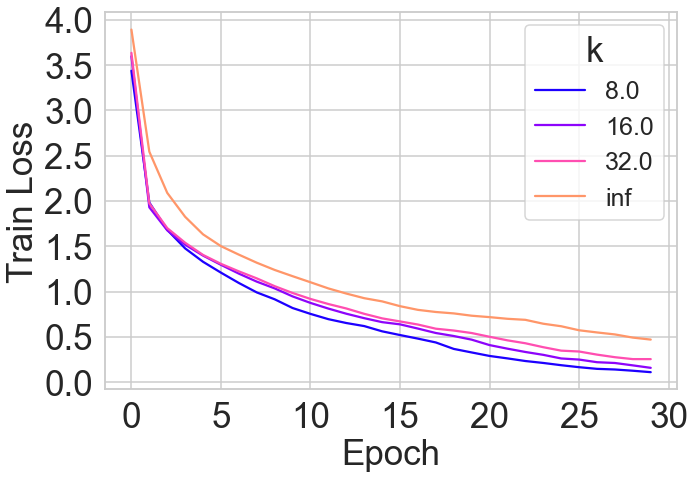

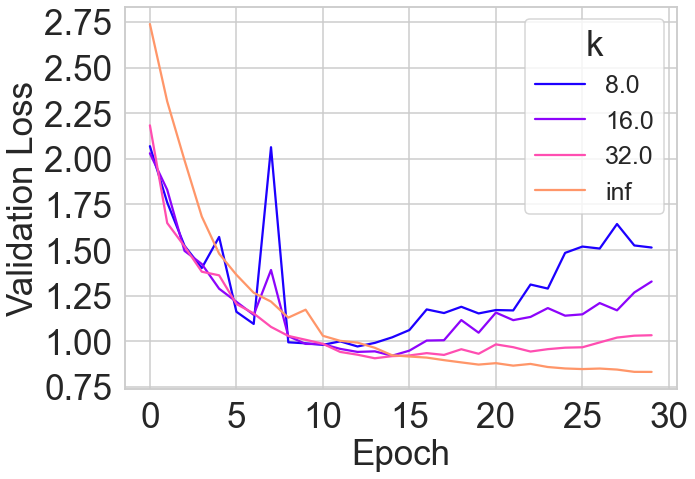

In [89]:
# get the difference between the parallelisms in terms of convergence

sns.set_style('whitegrid')
# sns.set_palette('gnuplot2')

r2 = sp[(sp.parallelism==2) & (sp.batch_size==128)].head(1).iloc[0]
r4 = sp[(sp.parallelism==4) & (sp.batch_size==128)].head(1).iloc[0]
r8 = sp[(sp.parallelism==8) & (sp.batch_size==128)].head(1).iloc[0]

e = 30
size=35

# Set the train loss
f, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x=range(e),
            y=r2.train_loss[:e],
            label=r2.parallelism)

sns.lineplot(x=range(e),
            y=r4.train_loss[:e],
            label=r4.parallelism)

sns.lineplot(x=range(e),
            y=r8.train_loss[:e],
            label=r8.parallelism)

plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.xlabel('Epoch', fontsize=size)
plt.ylabel('Train Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=25, title_fontsize=size)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/lines/train-parallelism.pdf')




# set the validation loss
f, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x=range(e),
            y=r2.validation_loss[:e],
            label=r2.parallelism)

sns.lineplot(x=range(e),
            y=r4.validation_loss[:e],
            label=r4.parallelism)

sns.lineplot(x=range(e),
            y=r8.validation_loss[:e],
            label=r8.parallelism)


plt.xlabel('Epoch', fontsize=size)
plt.ylabel('Validation Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=25, title_fontsize=size)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/lines/validation-parallelism.pdf')




# now do so in terms of K
ks = r[(r.system=='kubeml') & (r.parallelism==4) & (r.batch_size==128)]
ks.k.value_counts()

k8 = ks[ks.k==8].head(1).iloc[0]
k16 = ks[ks.k==16].head(1).iloc[0]
k32 = ks[ks.k==32].head(1).iloc[0]
kinf = ks[ks.k==float('inf')].head(1).iloc[0]

e = kinf.epochs


# Set the train loss
f, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x=range(e),
            y=k8.train_loss,
            label=k8.k)

sns.lineplot(x=range(e),
            y=k16.train_loss,
            label=k16.k)

sns.lineplot(x=range(e),
            y=k32.train_loss,
            label=k32.k)

sns.lineplot(x=range(e),
            y=kinf.train_loss,
            label=kinf.k)

# size=25
plt.xlabel('Epoch', fontsize=size)
plt.ylabel('Train Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='k', fontsize=25, title_fontsize=size)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/lines/train-k.pdf')

# plt.legend(title='k')


# set the validation loss
f, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x=range(e),
            y=k8.validation_loss,
            label=k8.k)

sns.lineplot(x=range(e),
            y=k16.validation_loss,
            label=k16.k)

sns.lineplot(x=range(e),
            y=k32.validation_loss,
            label=k32.k)


sns.lineplot(x=range(e),
            y=kinf.validation_loss,
            label=kinf.k)


plt.xlabel('Epoch', fontsize=size)
plt.ylabel('Validation Loss', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='k', fontsize=25, title_fontsize=size)

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/lines/validation-k.pdf')




In [9]:
sp[sp.system=='tensorflow']

,model,hash,batch_size,epochs,train_loss,train_accuracy,validation_loss,accuracy,epoch_duration,acc,...,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,parallelism,global_batch
0,resnet,44d99b585ec15030,32,70,"[2.440882444381714, 1.9447448253631592, 1.7837...","[0.17066000401973724, 0.26809999346733093, 0.3...","[2.0373032093048096, 1.7875392436981201, 1.791...","[21.709999442100525, 31.139999628067017, 38.22...","[90.5465760231018, 167.67973113059998, 243.727...",70.819998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,resnet,5d4210e3130a9739,128,70,"[2.7905611991882324, 1.7551709413528442, 1.588...","[0.20681999623775482, 0.3425599932670593, 0.42...","[1.957597017288208, 1.6984312534332275, 1.5086...","[25.65999925136566, 36.8800014257431, 44.74999...","[34.91643500328064, 55.42659902572632, 75.9164...",68.580002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,resnet,897dac71b62ec136,256,70,"[2.588197708129883, 1.6263797283172607, 1.4347...","[0.283160001039505, 0.4254800081253052, 0.4895...","[2.97422456741333, 1.4934394359588623, 1.49471...","[25.940001010894775, 46.11999988555908, 47.929...","[28.42989730834961, 40.05997085571289, 51.5759...",69.830000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,resnet,ad67202e9061c34e,64,70,"[2.3951144218444824, 1.7598485946655273, 1.599...","[0.2266400009393692, 0.35763999819755554, 0.42...","[1.9135148525238037, 1.7065120935440063, 1.471...","[27.559998631477356, 36.410000920295715, 47.04...","[53.67754888534546, 92.38472270965576, 131.467...",70.789999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,resnet,44d99b585ec15030,32,70,"[2.3818185329437256, 1.8773642778396606, 1.776...","[0.18386000394821167, 0.2983599901199341, 0.36...","[1.942749261856079, 1.838205099105835, 1.63964...","[26.53000056743622, 34.56999957561493, 43.0400...","[96.54499387741089, 177.19756150245667, 256.99...",71.450001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,resnet,5d4210e3130a9739,128,70,"[2.751002073287964, 1.7799159288406372, 1.6000...","[0.20479999482631683, 0.3450799882411957, 0.42...","[2.1896557807922363, 1.725273847579956, 1.7479...","[20.76999992132187, 36.86000108718872, 37.5, 4...","[36.689316272735596, 58.4234185218811, 80.2069...",71.880001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,resnet,897dac71b62ec136,256,70,"[3.0350117683410645, 1.901780366897583, 1.6201...","[0.22387999296188354, 0.335640013217926, 0.417...","[1827.414794921875, 2.613391160964966, 1.87475...","[10.480000078678131, 22.73000031709671, 32.170...","[28.405287981033325, 40.322970390319824, 51.82...",66.600001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,resnet,ad67202e9061c34e,64,70,"[2.4347894191741943, 1.7202712297439575, 1.561...","[0.23890000581741333, 0.3774400055408478, 0.44...","[2.0604264736175537, 1.8974347114562988, 1.554...","[28.439998626708984, 33.53999853134155, 48.660...","[56.1527099609375, 97.59916090965271, 139.2464...",70.190001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,resnet,44d99b585ec15030,32,70,"[2.4327855110168457, 1.8787837028503418, 1.705...","[0.1796800047159195, 0.310699999332428, 0.3950...","[1.9519758224487305, 1.7863093614578247, 2.088...","[26.179999113082886, 37.290000915527344, 39.77...","[96.81992959976196, 177.93973994255066, 258.48...",69.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,resnet,5d4210e3130a9739,128,70,"[2.6905786991119385, 1.771224021911621, 1.5848...","[0.21021999418735504, 0.3513599932193756, 0.43...","[2.1117124557495117, 1.7884496450424194, 1.717...","[19.419999420642853, 34.20000076293945, 37.909...","[35.701154470443726, 56.57576775550842, 77.755...",68.000001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compare GPU usage

In [ ]:
tf.epoch_duration

[2021-05-17 18:52:52,838] DEBUG    Assigning font /b'F1' = 'C:\\Windows\\Fonts\\arial.ttf'
[2021-05-17 18:52:52,859] DEBUG    Embedding font C:\Windows\Fonts\arial.ttf.
[2021-05-17 18:52:52,859] DEBUG    Writing TrueType font.


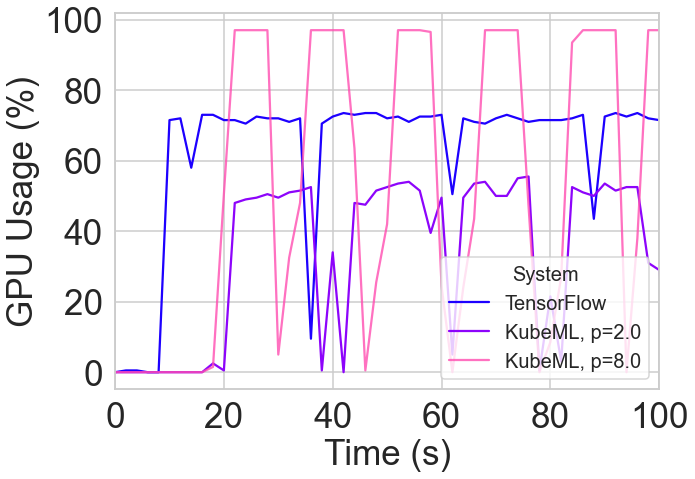

In [83]:
def calculate_gpu_usage(df):
    gpu = []
    for g0, g1 in zip(df.gpu_0, df.gpu_1):
        gpu.append(100 * (g0.load + g1.load)/2)
    return gpu

# plot gpu usage of different parallelisms



tf = sp[(sp.system=='tensorflow') & (sp.batch_size ==64)].head(1).iloc[0]
x = np.arange(0,2*len(tf.gpu_0), 2)
# Set the train loss
f, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x=x,
            y=calculate_gpu_usage(tf),
            label='TensorFlow')

x = np.arange(0,2*len(r2.gpu_0), 2)
sns.lineplot(x=x,
            y=calculate_gpu_usage(r2),
            label=f'KubeML, p={r2.parallelism}')

# x = np.arange(0,2*len(r4.gpu_0), 2)
# sns.lineplot(x=x,
#             y=calculate_gpu_usage(r4),
#             label=r4.parallelism,
#             alpha=0.6)

x = np.arange(0,2*len(r8.gpu_0), 2)
sns.lineplot(x=x,
            y=calculate_gpu_usage(r8),
            label=f'KubeML, p={r8.parallelism}',
            alpha=0.8)


plt.xlabel('Time (s)', fontsize=size)
plt.ylabel('GPU Usage (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='System', fontsize=20, title_fontsize=20, loc=4)
plt.xlim([0, 100])

plt.tight_layout()
plt.savefig('./figures/paper/resnet34/lines/gpu-usage.pdf')

## Do the same plot for the lenet

In [78]:
l4.gpu_0

nan

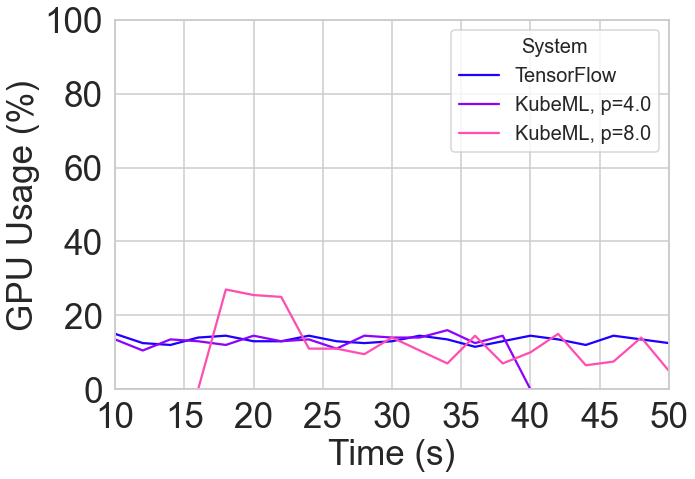

In [90]:
l = pd.read_pickle('./dataframes/lenet.pkl')

l2 = l[(l.parallelism==2) & (l.batch_size==128) & (l.k==float('inf'))].head(1).iloc[0]
l4 = l[(l.parallelism==4) & (l.batch_size==128) & (l.k==float('inf'))].head(2).iloc[1]
l8 = l[(l.parallelism==8) & (l.batch_size==128) & (l.k==float('inf'))].head(1).iloc[0]

tf = l[(l.system=='tensorflow') & (l.batch_size ==128)].head(1).iloc[0]
x = np.arange(0,2*len(tf.gpu_0), 2)


f, ax = plt.subplots(figsize=(10,7))

sns.lineplot(x=x,
            y=calculate_gpu_usage(tf),
            label='TensorFlow')

# x = np.arange(0,2*len(l2.gpu_0), 2)
# sns.lineplot(x=x,
#             y=calculate_gpu_usage(l2),
#             label=f'KubeML, p={l2.parallelism}')

x = np.arange(0,2*len(l4.gpu_0), 2)
sns.lineplot(x=x,
            y=calculate_gpu_usage(l4),
            label=f'KubeML, p={l4.parallelism}',
            )

x = np.arange(0,2*len(l8.gpu_0), 2)
sns.lineplot(x=x,
            y=calculate_gpu_usage(l8),
            label=f'KubeML, p={l8.parallelism}',
            )


plt.xlabel('Time (s)', fontsize=size)
plt.ylabel('GPU Usage (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='System', fontsize=20, title_fontsize=20)
plt.xlim([10, 50])
plt.ylim([0, 100])


plt.tight_layout()
# plt.savefig('./figures/paper/lenet/gpu-usage.pdf')

## Plot epoch duration by config

In [ ]:
# do the same as in the previous attempts but evaluate tta comparing tf wit all the parallelisms and k

def compute_epoch_duration(v):
    # returns a list with the durations of each epoch
    res = []
    for i, num in enumerate(v):
        if i == 0:
            res.append(num)
        else:
            res.append(num - v[i-1])
    
    return np.mean(res)
        


sns.set_palette('gnuplot2')

# plt.rc('font', size=25)

tf = r[r.system=='tensorflow']
kubeml = r[r.system=='kubeml']
sp = sp[sp.system=='kubeml']

# set the local batch variable
tf['local_batch'] = tf['batch_size']/2
kubeml['local_batch'] = kubeml['batch_size']
sp['local_batch'] = sp['batch_size']

# define a new variable configuration, which will define the tf and each of the kubeml configurations
tf['config']= 'tensorflow'
kubeml['config'] = kubeml.parallelism.map(lambda v: f'kubeml p={v}')
sp['config'] = sp.parallelism.map(lambda v: f'kubeml p={v}')

sp = sp[sp.k==float('inf')]
kubeml = kubeml[kubeml.k==float('inf')]


# combine the dfs
df = pd.concat([tf,kubeml, sp], ignore_index=True)


# compute time_per_epoch
df['tpe'] = df.epoch_duration.map(lambda l: compute_epoch_duration(l))

# get the mean epoch duration and from there the average throughput knowing that 
# we process 50K images per epoch

num_img = 50000
df['throughput'] = num_img/df['tpe']
df = df[df.local_batch >16]




# plot the different configs

f = plt.subplots(figsize=(10,7))
sns.barplot(x='local_batch',
           y='time',
           hue='config',
            errcolor='gray',
            errwidth=2.5,
            capsize=.05,
           data=df)

plt.xlabel('Batch Size')
plt.ylabel('Time')


In [ ]:
df[df.system=='tensorflow'].epochs

---

## Get the results for the lenet on multiple nodes CPU

In [91]:
df = pd.read_pickle('./dataframes/lenet-cpu-6-workers.pkl')

In [99]:
df.epochs

0     30
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
Name: epochs, dtype: int64

In [146]:
df[df.parallelism==8].time.mean()

263.5561480806667

In [149]:
l[(l.parallelism==8) & (l.batch_size==64) & (l.k==float('inf'))].memory_usage_mean

99     11.800000
119     9.606061
155     9.448485
Name: mem_mean, dtype: float64

In [151]:
d = pd.read_pickle('./results/old/resnet_36exp.pkl')
# d[(d.default_parallelism==8) & (d.k)]
d[(d.default_parallelism==8) & (d.batch_size==128)].epochs

0     1
19    1
23    1
Name: epochs, dtype: int64

In [130]:
d

,id,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration
0,03da5d25,example,128,1,cifar10,0.1,resnet,8,True,1,8,100,[1.9938284747208221],[26.41],[3.609585141763091],[8],[577.992817891]
1,231943ff,example,128,1,cifar10,0.1,resnet,32,True,1,8,100,[175.9012781457056],[10],[6.146889317873865],[32],[255.3115073]
2,2aaa8a3d,example,32,1,cifar10,0.1,resnet,32,True,1,64,100,[6.456673442365262],[10],[8.465176700492991],[32],[628.306893289]
3,2ec1758f,example,64,1,cifar10,0.1,resnet,32,True,1,16,100,[4.153203514730855],[10],[5.782667923899782],[32],[414.973165487]
4,350e0676,example,64,1,cifar10,0.1,resnet,32,True,1,64,100,[6.385458897633158],[10],[7.8308387949814415],[32],[415.313563337]
5,38e2cee0,example,64,1,cifar10,0.1,resnet,4,True,1,64,100,[2.2510791660114458],[12.67],[3.3085530520183966],[4],[775.765169334]
6,3cb67a42,example,32,1,cifar10,0.1,resnet,32,True,1,8,100,[2.176307292791982],[21.16],[4.656333648366854],[32],[711.845770001]
7,48989c6d,example,64,1,cifar10,0.1,resnet,16,True,1,64,100,[6.321385304639294],[10],[6.414901958138612],[16],[424.169764306]
8,4cf3c3d1,example,128,1,cifar10,0.1,resnet,32,True,1,64,100,[3.2593925180314463],[10],[6.321312318627649],[32],[231.404655465]
9,56b29127,example,32,1,cifar10,0.1,resnet,8,True,1,8,100,[2.2803320846618553],[31.3],[3.3851919494569302],[8],[886.874961812]


In [143]:
sp[(sp.parallelism==8) & (sp.batch_size==128)].mem_mean

34    14.100000
42    13.990323
47    14.889506
Name: mem_mean, dtype: float64

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

size=30

# print(_kuberesnet.parallelism.value_counts())
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=df, 
            errwidth=2.5,
            capsize=.05,
            errcolor='gray',
           hue='parallelism',
           )
plt.ylim([0, 700])
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Time (sec)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='Parallelism', fontsize=25, bbox_to_anchor=(1, 0.75), frameon=False)
# plt.legend().remove()

# for bar in ax.patches:
#     bar.set_width(.1)

sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/cpu/time.pdf')



f, ax = plt.subplots(figsize=(10,7))
# print(_kuberesnet.parallelism.value_counts())
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='acc',
           data=df, 
            errwidth=2.5,
            capsize=.05,
            errcolor='gray',
           hue='parallelism',
           )
plt.xlabel('Batch Size', fontsize=size)
plt.ylabel('Accuracy (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.ylim([84, 100])
plt.legend(title='Parallelism', fontsize=25, bbox_to_anchor=(1, 0.75), frameon=False).remove()


sns.despine(left=True)

plt.tight_layout()
plt.savefig('./figures/paper/cpu/accuracy.pdf')

---

# Analize results using ResNet32 for 200 epochs

In [ ]:
# load the dataframes
r32 = pd.read_pickle('./dataframes/resnet32-200.pkl')
r128 = pd.read_pickle('./dataframes/resnet32-200-128.pkl')

### Analysis of the batch 32 

In [ ]:
sns.set_palette('gnuplot2')

# get an intuition of the comparison with and without momentum by plotting the accuracy progression
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

f, ax = plt.subplots(figsize=(14,10))

size=40

# plot all the lines
for _, row in r32.sort_values('k').iterrows():
    if not row.momentum:
        sns.lineplot(
            x=row.epoch_duration,
            y=row.accuracy,
            label=f'{int(row.k) if row.k != float("inf") else row.k}'
        )
        
# set the axes names
ax.set_xlabel('Time (sec)', fontsize=size)
ax.set_ylabel('Accuracy (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(title='k', fontsize=30)

ax.set_ylim([30, 94])
        
axins = zoomed_inset_axes(ax, zoom= 3, bbox_to_anchor=(700, 500))
for i, row in r32.sort_values('k').iterrows():
    if not row.momentum:
        axins.plot(
            row.epoch_duration,
            row.accuracy
        )
        
ax.get_legend().set_title('K')
ax.get_legend()._set_loc(4)
        
axins.set_ylim([84, 91])
axins.set_xlim([1200, 2200])

# plt.xticks(visible=False)
# plt.yticks(visible=False)


mark_inset(ax, axins, loc1=2, loc2=1, ec="0.5");

plt.tight_layout()
plt.savefig('./figures/paper/resnet32/resnet32-32-comparison.pdf')

## Compare the train loss and the val loss

In [ ]:
f, ax = plt.subplots(figsize=(14,10))

size=40

# plot all the lines
for _, row in r32.sort_values('k').iterrows():
    if not row.momentum:
        sns.lineplot(
            x=range(200),
            y=row.validation_loss,
            label=f'{int(row.k) if row.k != float("inf") else row.k}'
        )
        
        
f, ax = plt.subplots(figsize=(14,10))

size=40

# plot all the lines
for _, row in r32.sort_values('k').iterrows():
    if not row.momentum:
        sns.lineplot(
            x=range(200),
            y=row.train_loss,
            label=f'{int(row.k) if row.k != float("inf") else row.k}'
        )

## Same with 128

In [ ]:
sns.set_palette('gnuplot2')

# get an intuition of the comparison with and without momentum by plotting the accuracy progression
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

f, ax = plt.subplots(figsize=(14,10))

# plot all the lines
for _, row in r128.sort_values('k').iterrows():
    if not row.momentum:
        sns.lineplot(
            x=row.epoch_duration,
            y=row.accuracy,
            label=f'{int(row.k) if row.k != float("inf") else row.k}'
        )
        
# set the axes names
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([30, 94])
        
axins = zoomed_inset_axes(ax, zoom= 2, bbox_to_anchor=(700, 500))
for i, row in r128.sort_values('k').iterrows():
    if not row.momentum:
        axins.plot(
            row.epoch_duration,
            row.accuracy
        )
        
ax.get_legend().set_title('K')
ax.get_legend()._set_loc(4)
        
axins.set_ylim([79, 86])
axins.set_xlim([700, 1100])

# plt.xticks(visible=False)
# plt.yticks(visible=False)


mark_inset(ax, axins, loc1=2, loc2=1, ec="0.5");

plt.tight_layout()
# plt.savefig('./figures/paper/resnet32/resnet32-32-comparison.pdf')

## Compare with the Momentum

In [ ]:
print(sns.color_palette('gnuplot2').as_hex())

In [ ]:
# get both of the entries with K = inf

sns.set_palette('gnuplot2')

inf = r32[r32.k==float('inf')]


f, ax = plt.subplots(figsize=(10,7))
# plot all the lines
for _, row in inf.sort_values('k').iterrows():

    color='#000090' if row.momentum else '#ff9669'
    label = 'SGD with Momentum' if row.momentum else 'SGD'
    
    sns.lineplot(
        x=row.epoch_duration,
        y=row.accuracy,
        label=label,
        color=color
    )
    
# set the axes names
ax.set_xlabel('Time (sec)', fontsize=size)
ax.set_ylabel('Accuracy (%)', fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=25)
ax.set_ylim([30, 92])
    
        
# ax.get_legend().set_title('Momentum')
ax.get_legend()._set_loc(4)

plt.tight_layout()
plt.savefig('./figures/paper/resnet32/resnet32-momentum-comparison.pdf')

---

## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [ ]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

__r = r[r.system=='kubeml']
__r['k'] = __r['k'].map(lambda v: -1 if v == float('inf') else v)
res, model = ANOVA(__r, y='gpu_usage', verbose=True)

res

